<a href="https://colab.research.google.com/github/Siddhartha-Patolia/my_projects/blob/main/LSTM_stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
df = yf.download("GOOG")
stock_price = df["Close"]
stock_price

[*********************100%%**********************]  1 of 1 completed


Date
2004-08-19      2.499133
2004-08-20      2.697639
2004-08-23      2.724787
2004-08-24      2.611960
2004-08-25      2.640104
                 ...    
2024-02-21    143.839996
2024-02-22    145.320007
2024-02-23    145.289993
2024-02-26    138.750000
2024-02-27    140.100006
Name: Close, Length: 4914, dtype: float64

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
mm = MinMaxScaler()
scaled_price = mm.fit_transform(np.array(stock_price)[..., None])
scaled_price

array([[5.39563192e-05],
       [1.35692365e-03],
       [1.53511972e-03],
       ...,
       [9.37314995e-01],
       [8.94387311e-01],
       [9.03248579e-01]])

In [6]:
days = 15
X = []
y = []
for i in range(days , len(scaled_price)):
  X.append(scaled_price[i-days : i])
  y.append(scaled_price[i])
print(len(X[0]) , len(X) , len(y))
print(X)
print(y)

Streaming output truncated to the last 5000 lines.
       [0.64377865]]), array([[0.69701166],
       [0.68913503],
       [0.70882665],
       [0.70186891],
       [0.71735965],
       [0.71795043],
       [0.67489139],
       [0.67856719],
       [0.66563636],
       [0.66386408],
       [0.66530814],
       [0.65204914],
       [0.64010289],
       [0.64377865],
       [0.63458921]]), array([[0.68913503],
       [0.70882665],
       [0.70186891],
       [0.71735965],
       [0.71795043],
       [0.67489139],
       [0.67856719],
       [0.66563636],
       [0.66386408],
       [0.66530814],
       [0.65204914],
       [0.64010289],
       [0.64377865],
       [0.63458921],
       [0.63222622]]), array([[0.70882665],
       [0.70186891],
       [0.71735965],
       [0.71795043],
       [0.67489139],
       [0.67856719],
       [0.66563636],
       [0.66386408],
       [0.66530814],
       [0.65204914],
       [0.64010289],
       [0.64377865],
       [0.63458921],
       [0.63222622]

In [7]:
X_train = X[:int(0.8*len(X))]
X_test = X[int(0.8*len(X)):]
y_train = y[:int(0.8*len(y))]
y_test = y[int(0.8*len(y)):]
print(len(X_train) , len(X_test) , len(y_train) , len(y_test))

3919 980 3919 980


In [8]:
X_train = torch.tensor(np.array(X_train)).float()
X_test = torch.tensor(np.array(X_test)).float()
y_train = torch.tensor(np.array(y_train)).float()
y_test = torch.tensor(np.array(y_test)).float()
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([3919, 15, 1])
torch.Size([980, 15, 1])
torch.Size([3919, 1])
torch.Size([980, 1])


In [9]:
from torch.utils.data import Dataset
class DataSet(Dataset):
  def __init__(self , X , y):
    self.X = X
    self.y = y
  def __len__(self):
    return len(self.X)
  def __getitem__(self , i):
    return self.X[i] , self.y[i]

train_data = DataSet(X_train , y_train)
test_data = DataSet(X_test , y_test)

In [10]:
from torch.utils.data import DataLoader
batch_size = 16
train = DataLoader(train_data , batch_size , shuffle = True)
test = DataLoader(test_data , batch_size , shuffle = False)

In [11]:
for batch in train:
  x_batch = batch[0].to(device)
  y_batch = batch[1].to(device)
print(x_batch.shape)

torch.Size([15, 15, 1])


In [12]:
num_of_stacked_layers = 1
class LSTM(nn.Module):
  def __init__(self , input_size , hidden_size , num_of_stacked_layers , batch_first = True):
    super().__init__()

    self.ht_size = hidden_size
    self.lstm = nn.LSTM(input_size , hidden_size , num_of_stacked_layers ,  batch_first = True)
    self.fc = nn.Linear(hidden_size , 1)
  def forward(self , x):
    batch_size = x.size(0);
    h0 = torch.randn(num_of_stacked_layers , batch_size , self.lstm.hidden_size).to(device)
    c0 = torch.randn(num_of_stacked_layers , batch_size , self.lstm.hidden_size).to(device)
    temp , _ = self.lstm(x , (h0 , c0))
    out = temp[:,-1,:]
    out = self.fc(out)
    return out

lstm_model = LSTM(1 , 150 , 1)
lstm_model.to(device)
lstm_model

LSTM(
  (lstm): LSTM(1, 150, batch_first=True)
  (fc): Linear(in_features=150, out_features=1, bias=True)
)

In [13]:
train_losses=[]
test_losses=[]

In [14]:
def train_model(loss_func , optimizer):
  lstm_model.train(True)
  net_loss = 0.0
  for i ,batch in enumerate(train):
    x_batch = batch[0].to(device)
    y_batch = batch[1].to(device)
    predicted = lstm_model(x_batch)
    loss = loss_func(predicted , y_batch)
    net_loss = net_loss + loss.item()
    optimizer.zero_grad()        #.item() converts the 1D tensor to a float scalar value.
    loss.backward()
    optimizer.step()
  print(net_loss/len(train))
  #save checkpoint
  path='/content/drive/MyDrive/checkpoint.pt'
  torch.save({'model_state_dict' : lstm_model.state_dict() , 'optimizer_dict' : optimizer.state_dict()} , path)
  return net_loss/len(train)

In [15]:
learning_rate = 0.0000001
optimizer = torch.optim.Adam(lstm_model.parameters() , learning_rate)
loss_func = nn.MSELoss().to(device)
x_batch = batch[0].to(device)
y_batch = batch[1].to(device)
predicted = lstm_model(x_batch)
init_loss = loss_func(predicted , y_batch)
print(init_loss)

tensor(0.0152, grad_fn=<MseLossBackward0>)


In [16]:
#Load Checkpoint


In [17]:
def test_model(loss_func , optimizer):
  lstm_model.eval()
  net_loss = 0.0
  for _ , batch in enumerate(test):
    x_batch = batch[0].to(device)
    y_batch = batch[1].to(device)
    with torch.no_grad():          #since backpropogation is not required.*****
      predicted = lstm_model(x_batch)
      loss = loss_func(predicted , y_batch)
      net_loss = net_loss + loss.item()
  total_avg_loss = net_loss/len(test)
  print('Val Loss: {0:.3f}'.format(total_avg_loss))
  print('***************************************************')
  print()
  return total_avg_loss


In [18]:
learning_rate = 0.00001
epochs = 100
optimizer = torch.optim.Adam(lstm_model.parameters() , learning_rate)
loss_func = nn.MSELoss().to(device)
for epoch in range(epochs):
  loss_train = train_model(loss_func , optimizer)
  train_losses.append(loss_train)
  loss_test = test_model(loss_func , optimizer)
  test_losses.append(loss_test)
  # test_model(loss_func , optimizer)

0.016377488513268073
Val Loss: 0.384
***************************************************

0.013164020945527115
Val Loss: 0.340
***************************************************

0.012158842439934307
Val Loss: 0.312
***************************************************

0.01129835371061095
Val Loss: 0.285
***************************************************

0.010168745213815448
Val Loss: 0.243
***************************************************

0.00846784621933285
Val Loss: 0.182
***************************************************

0.0058512189853176175
Val Loss: 0.088
***************************************************

0.0036602149688999873
Val Loss: 0.035
***************************************************

0.0025838265062442848
Val Loss: 0.014
***************************************************

0.0018017033556932394
Val Loss: 0.007
***************************************************

0.0011646376603178452
Val Loss: 0.005
***************************************************

0.00071

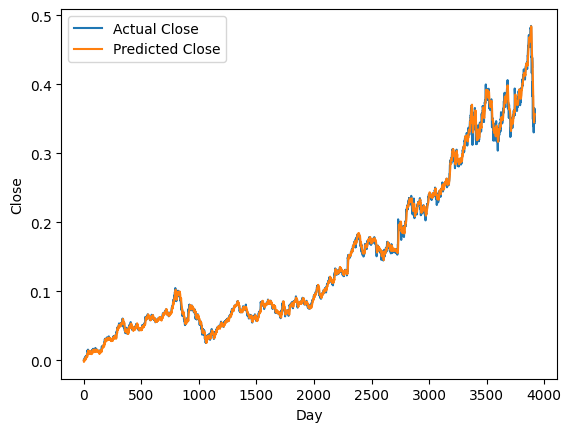

In [19]:
with torch.no_grad():
    predicted = lstm_model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

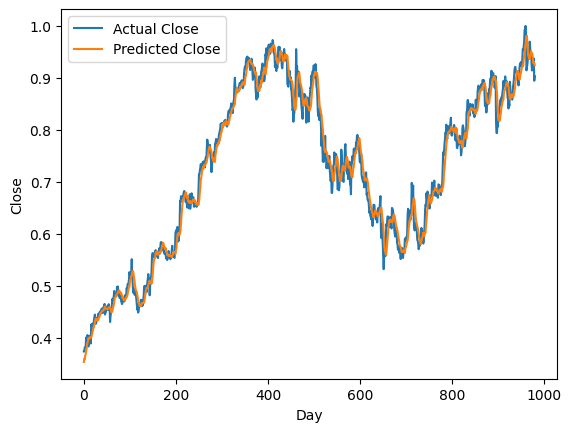

In [20]:
with torch.no_grad():
    predicted = lstm_model(X_test.to(device)).to('cpu').numpy()

plt.plot(y_test, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test , predicted)
r2
#the closer to 1 the better. It shows how closely the model follows the actual values.

0.9796976877941631

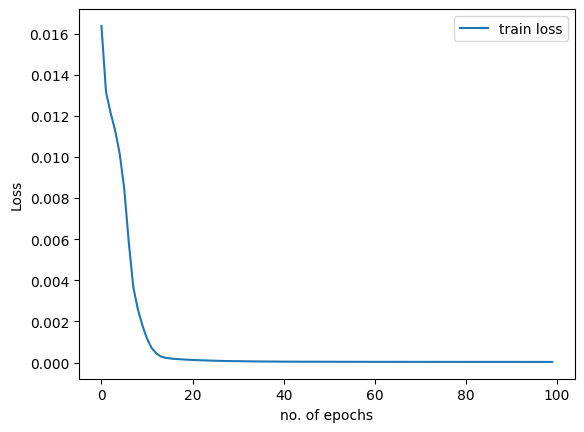

In [22]:
plt.plot(train_losses  , label = 'train loss')
plt.xlabel('no. of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

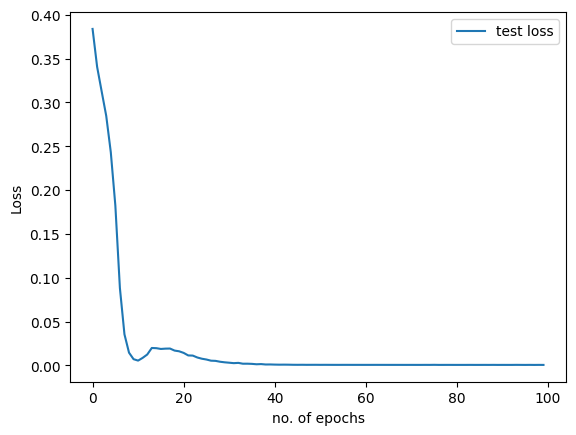

In [23]:
plt.plot(test_losses , label = 'test loss')
plt.xlabel('no. of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Inference


In [24]:
#load checkpoint
checkpoint = torch.load('/content/drive/MyDrive/checkpoint.pt')
lstm_model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']
lstm_model.eval()

LSTM(
  (lstm): LSTM(1, 150, batch_first=True)
  (fc): Linear(in_features=150, out_features=1, bias=True)
)

In [25]:
x_batch = #input data
predicted = lstm_model(x_batch)
print(predicted)
# this is for using the model for further predictions.

SyntaxError: invalid syntax (<ipython-input-25-a7d2e7761917>, line 1)